# End-to-end COCO Demo

This shows the reasonableness monitor, the explanation synthesizer, and Glove on a COCO sample and annotation.

## Pre-processing to get the image from COCO

In [1]:
## Imports that are necessary for COCO

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Imports for Glove

In [2]:
#Imports for Glove
#Imports Cell
from collections import defaultdict
import numpy as np
import gensim
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline

#Put the path to glove here
# path = r"C:/Users/Vishn/Downloads/glove.6B.50d.txt.w2v"
path = "/Users/leilani/workspace/glove/glove.6B.50d.txt.w2v"

#Now load the model into the variable "glove" (may take some time)
glove = KeyedVectors.load_word2vec_format(path, binary=False)

In [3]:
# Function based on all the computations above
def calcuate_distances(label_set_a:list, 
                       label_set_b:list) -> np.ndarray:
    """
    This function takes in two sets of glove embeddings vectors and returns the min distances between the two
    
    Parameters
    -------------    
    label_set_a : list 
            the first set of glove embedding vectors from one input source
    label_set_b : list
            the second set of glove embedding vectors from the second source
    
    Returns
    ---------
    numpy.ndarray
        The list of distances, where length = max(len(label_set_a),len(label_set_b))
    """
    
    #Turn both into numpy arrays
    arr_a = np.array(label_set_a)
    arr_b = np.array(label_set_b)
    
    #Square and transform as needed
    a = np.sum(arr_a**2,axis = 1)[:,np.newaxis]
    b = np.sum(arr_b**2,axis = 1)
    
    #Calculate the distances and take the square root
    #We are also cutting off where values too small
    dists = a + b - 2*np.matmul(arr_a,arr_b.T)
    dists[dists < 1e-6] = float(0.0)
    dists = np.sqrt(dists)
    
    #Return the minimum values across the axis with more glove embeddings
    return np.min(dists,axis = np.argmax(dists.shape))

# Function based on all the computations above
def calcuate_distance(label_set_a:list, 
                       label_set_b:list) -> np.ndarray:
    """
    This function takes in two sets of glove embeddings vectors and returns a single value representing the distance between the two values
    
    Parameters
    -------------    
    label_set_a : list 
            the first set of glove embedding vectors from one input source
    label_set_b : list
            the second set of glove embedding vectors from the second source
    
    Returns
    ---------
    float32
        A single value representing the distance between label_set_a and label_set_b
    """
    
    #Turn both into numpy arrays
    arr_a = np.array(label_set_a)
    arr_b = np.array(label_set_b)
    
    #Square and transform as needed
    a = np.sum(arr_a**2,axis = 1)[:,np.newaxis]
    b = np.sum(arr_b**2,axis = 1)
    
    #Calculate the distances and take the square root
    #We are also cutting off where values too small
    dists = a + b - 2*np.matmul(arr_a,arr_b.T)
    dists[dists < 1e-6] = float(0.0)
    dists = np.sqrt(dists)
    
    #Return the minimum values across the axis with more glove embeddings
    return np.sum(np.min(dists,axis = np.argmin(dists.shape)))

def gen_domain(list_domain:list, depth:int) -> set:
    """
    This function takes in a list of strings, which represents the domain, and generates the relavent list of glove embeddings that represents this domain. 
    
    This does it through a recursive methodology
    
    
    Parameters
    -------------
    list_domain: list
    List of string terms that represent the domain
    
    depth: int
    How many layers should be used to generate the domain
    
    Returns
    ---------
    Set of strings of the terms that we should get the glove embeddings for
    """
    

    list_embeddings = set() #The final set representing the domain embeddings
    
    if depth == 0: #If we have gotten back to depth 0 it means we have added all the words to the depth we want
        return list_embeddings
    
    
    #We will use a BFS type function to generate our domain
    queue = set(list_domain)
    
    for word in queue: #For each domain word
        
        #Add the first thing in the queue to our list
        list_embeddings.add(word)
        
        #Get similar terms
        list_terms = set(word for word, similarity in glove.similar_by_vector(glove[word]))
        #Add its most similar words using a recursive call
        list_embeddings.update(gen_domain(list_terms, depth - 1))
    
    return list_embeddings    

def gen_thresh_domain(list_domain:list, depth:int, threshold=0.7) -> set:
    """
    This function takes in a list of strings, which represents the domain, and generates the relavent list of glove embeddings that represents this domain. 
    
    This does it through a recursive methodology and uses a threshold value to make sure that only relavent values are pulled up.
    
    
    Parameters
    -------------
    list_domain: list
    List of string terms that represent the domain
    
    depth: int
    How many layers should be used to generate the domain
    
    threshold: float
    The similarity threshold that we will only add values above, by default = 0.7
    
    Returns
    ---------
    Set of strings of the terms that we should get the glove embeddings for
    """
    

    list_embeddings = set() #The final set representing the domain embeddings
    
    if depth == 0: #If we have gotten back to depth 0 it means we have added all the words to the depth we want
        return list_embeddings
    
    
    #We will use a BFS type function to generate our domain
    queue = set(list_domain)
 
    for word in queue: #For each domain word
        
        #Add the first thing in the queue to our list
        list_embeddings.add(word)
        
        #Get similar terms
        list_terms = set(word for word, similarity in glove.similar_by_vector(glove[word]) if similarity >= threshold)
        
        #Add its most similar words using a recursive call
        list_embeddings.update(gen_thresh_domain(list_terms, depth - 1))
    
    return list_embeddings    

def convert_to_embeddings(domain:set) -> list:
    """
    Converts the domain of terms to a list of related embeddings
    
    Parameters
    -------------
    domain: set
    The set of terms that define the domain, each term is a string
    
    Returns
    ---------
    list of glove embeddings
    """
    return [glove[word] for word in domain]

list_of_stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
import string
def gen_cap_terms(caption:str) -> list:
    """
    This function takes in a caption as a string and will return a list of the most important words that are also found in Glove
    
    Parameters
    -------------
    caption : str
        The caption in a string form
    
    Returns
    ---------
    set[str]
        Returns a set of important terms recognized by Glove as a String
    """
    caption = "".join(token for token in caption if token not in string.punctuation)

    caption_list = caption.split() #Tokenizes the words
    
    ret_set = set()  #set of terms we will return
    
    for word in caption_list:
        if word not in list_of_stop_words and word in glove:
            ret_set.add(word)
    
    return ret_set

set_verbs = set() #Set of Terms

f = open("verbsList.txt", "r")
for x in f:
  set_verbs.add(x[:-1])
f.close()

In [4]:
dataDir='/Users/leilani/Dropbox (MIT)/car-can-explain/data/coco/'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [5]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=20.55s)
creating index...
index created!


In [6]:
# get all images containing given categories, select one at random
# catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
# imgIds = coco.getImgIds(catIds=catIds );
img_id = 116074 # Our test image. 
imgIds = coco.getImgIds(imgIds = [img_id])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread(img['coco_url'])

In [7]:
# initialize COCO api for caption annotations
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=1.30s)
creating index...
index created!


A man looks at his cellphone while standing next to a motorcycle.
a man wearing a helmet using a cellular phone while standing next to a motorcycle.
A man using a phone next to a motorcycle
A man wearing a motorcycle helmet while holding a cell phone.
A guy standing next to a motorcycle on the phone.


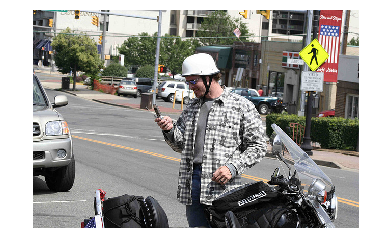

In [8]:
# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()

# Reasonableness Monitor processing.

- Parse captions in a common form (representation).

In [9]:
import sys
sys.path.append('../') # This is a hack!

import synthesizer.synthesize as synthesize
import monitor.reasonableness_monitor as monitor
import monitor.representation as rep
from sympy import *  # python symbolic package

from nltk.tree import Tree
from IPython.display import display
import IPython

A man looks at his cellphone while standing next to a motorcycle.


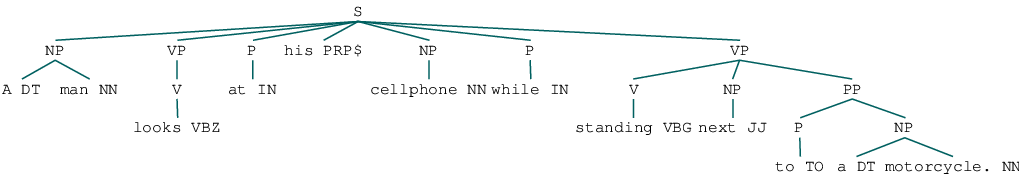

In [10]:
all_annotations = []


# To do all the annotations
# for annotation in anns:
#     print(annotation['caption'])
#     tokens = annotation['caption'].split()
#     result = rep.parse_with_regex(tokens)

#     tree = Tree.fromstring(str(result))
#     IPython.core.display.display(result)
#     all_annotations.append(annotation['caption'])
    
annotation = anns[0]
print(annotation['caption'])
tokens = annotation['caption'].split()
tree = rep.parse_with_regex(tokens)

#tree = Tree.fromstring(str(result))
IPython.core.display.display(tree)
all_annotations.append(annotation['caption'])

concepts = rep.get_concepts(tree)

(noun, noun_phrase, adjectives) = rep.get_noun_phrase(tree)
(verb, obj, context, phrase_dict) = rep.get_verbs(tree, True)

In [11]:
concepts
labels = symbols('man motorcycle cellphone')

In [12]:
monitor.snapshotMonitor(labels)

REASONS ARE [['man IsA person', 'ConceptNet IsA link']]
REASONS ARE [['man IsA person', 'ConceptNet IsA link'], ['motorcycle IsA object', 'Default anchor point']]
REASONS ARE [['man IsA person', 'ConceptNet IsA link'], ['motorcycle IsA object', 'Default anchor point'], ['cellphone IsA object', 'Default anchor point']]
REASONS ARE [['man IsA person', 'ConceptNet IsA link'], ['motorcycle IsA object', 'Default anchor point'], ['cellphone IsA object', 'Default anchor point'], ['motorcycle AtLocation garage', 'ConceptNet'], ['motorcycle AtLocation motorcycle', 'ConceptNet']]
Are we here in reasonable (man, motorcycle, cellphone)


(True,
 'This vision system is reasonable.  There is commonsense supporting the same location between man, motorcycle, cellphone')

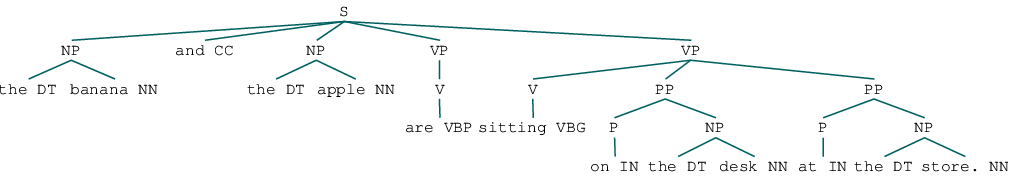

REASONS ARE [['banana IsA object', 'Default anchor point']]
REASONS ARE [['banana IsA object', 'Default anchor point'], ['desk IsA place', 'ConceptNet IsA link']]
REASONS ARE [['banana IsA object', 'Default anchor point'], ['desk IsA place', 'ConceptNet IsA link'], 'IsA relation not found between concept and anchors']
REASONS ARE [['banana IsA object', 'Default anchor point'], ['desk IsA place', 'ConceptNet IsA link'], 'IsA relation not found between concept and anchors', ['desk AtLocation desk', 'ConceptNet'], ['desk AtLocation your_desk', 'ConceptNet']]


AssertionError: 2 columns passed, passed data had 50 columns

In [13]:
new_sentence = 'the banana and the apple are sitting on the desk at the store.'
tokens = new_sentence.split()
tree = rep.parse_with_regex(tokens)

IPython.core.display.display(tree)

concepts = rep.get_concepts(tree)

(noun, noun_phrase, adjectives) = rep.get_noun_phrase(tree)
(verb, obj, context, phrase_dict) = rep.get_verbs(tree, True)
concepts = rep.get_concepts(tree)
context = False
monitor.snapshotMonitor(concepts, context)

# Glove Related Code

In [ ]:
depth = 4
domain = convert_to_embeddings(set(word for word in gen_thresh_domain(["car","stoplight","motorcycle"], depth) if word not in set_verbs))
#This cell will generate the domain that we plan to use

In [ ]:
# b = gen_thresh_domain(["stop","stoplight"], 2)
# len(b)

In [ ]:
print(gen_cap_terms(annotation['caption']))

In [ ]:
#All test are from one image Sim Image A
test = anns[0]['caption']
test2 = anns[1]['caption']
diff1 = anns[2]['caption']
diff2 = anns[3]['caption']
print(test)
print(test2)
print(diff1)
print(diff2)